In [1]:
import zipfile
!unzip /content/utils.zip

Archive:  /content/utils.zip
   creating: utils/__pycache__/
  inflating: utils/__pycache__/Geom.cpython-38.pyc  
  inflating: utils/__pycache__/Geom_examples.cpython-38.pyc  
  inflating: utils/__pycache__/scipy_loss.cpython-38.pyc  
  inflating: utils/__pycache__/tfp_loss.cpython-38.pyc  
  inflating: utils/Geom.py           
  inflating: utils/Geom_examples.py  
  inflating: utils/Plotting.py       
  inflating: utils/scipy_loss.py     
  inflating: utils/Solvers.py        
  inflating: utils/tfp_loss.py       


In [2]:
!pip install geomdl

     |████████████████████████████████| 147 kB 5.2 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import time
from utils.tfp_loss import tfp_function_factory
from utils.Geom_examples import Quadrilateral
#from utils.Solvers import Poisson2D_coll
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
#make figures bigger on HiDPI monitors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
tf.random.set_seed(42)
 

In [4]:
class model(tf.keras.Model):     
    def __init__(self, layers, train_op, num_epoch, print_epoch):
        super(model, self).__init__()
        self.model_layers = layers
        self.train_op = train_op
        self.num_epoch = num_epoch
        self.print_epoch = print_epoch
            
    def call(self, X):
        return self.u(X[:,0:1], X[:,1:2])
    
    # Running the model
    @tf.function
    def u(self, xPhys, yPhys):
        X = tf.concat([xPhys, yPhys],1)
        X = 2.0*(X - self.bounds["lb"])/(self.bounds["ub"] - self.bounds["lb"]) - 1.0
        for l in self.model_layers:
            X = l(X)
        return X
    
    # Return the first derivatives
    @tf.function
    def du(self, xPhys, yPhys):        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            u_val = self.u(xPhys, yPhys)
        dudx_val = tape.gradient(u_val, xPhys)
        dudy_val = tape.gradient(u_val, yPhys)
        del tape
        return dudx_val, dudy_val
    
    # Return the second derivative
    @tf.function
    def d2u(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            dudx_val, dudy_val = self.du(xPhys, yPhys)
        d2udx2_val = tape.gradient(dudx_val, xPhys)
        d2udy2_val = tape.gradient(dudy_val, yPhys)
        del tape        
        return d2udx2_val, d2udy2_val

    # Return the third derivative
    @tf.function
    def d3u(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            d2udx2_val, d2udy2_val = self.d2u(xPhys, yPhys)
        d3udx3_val = tape.gradient(d2udx2_val, xPhys)
        d3udy3_val = tape.gradient(d2udy2_val, yPhys)
        d3udx2dy_val = tape.gradient(d2udx2_val, yPhys)
        del tape        
        return d3udx3_val, d3udy3_val, d3udx2dy_val

     # Return the fourth derivative
    @tf.function
    def d4u(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            d3udx3_val, d3udy3_val, d3udx2dy_val = self.d3u(xPhys, yPhys)
        d4udx4_val = tape.gradient(d3udx3_val, xPhys)
        d4udy4_val = tape.gradient(d3udy3_val, yPhys)
        d4udx2dy2_val = tape.gradient(d3udx2dy_val, yPhys)
        del tape        
        return d4udx4_val, d4udy4_val, d4udx2dy2_val       
         
    #Custom loss function
    @tf.function
    def get_loss(self,Xint, Yint, Xbnd, Ybnd, Mbnd):
        u_val_bnd = self.call(Xbnd)
        xPhys = Xint[:,0:1]
        yPhys = Xint[:,1:2]
        
        d2udx2_val_int, d2udy2_val_int = self.d2u(xPhys, yPhys)
        d4udx4_val_int, d4udy4_val_int, d4udx2dy2_val = self.d4u(xPhys, yPhys)
        f_val_int = (d4udx4_val_int + d4udy4_val_int+2*d4udx2dy2_val)
        int_loss = tf.reduce_mean(tf.math.square(f_val_int - Yint))
        wbnd_loss = tf.reduce_mean(tf.math.square(u_val_bnd - Ybnd))

        xPhysbnd = Xbnd[:,0:1]
        yPhysbnd = Xbnd[:,1:2]

        d2udx2_val_intbnd, d2udy2_val_intbnd = self.d2u(xPhysbnd, yPhysbnd)
        M_val_bnd = -(d2udx2_val_intbnd + 0.3*d2udy2_val_intbnd)
        Mbnd_loss = tf.reduce_mean(tf.math.square(M_val_bnd - Mbnd))
        return int_loss+wbnd_loss+Mbnd_loss
      
    # get gradients
    @tf.function
    def get_grad(self, Xint, Yint, Xbnd, Ybnd, Mbnd):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(Xint, Yint, Xbnd, Ybnd, Mbnd)
        g = tape.gradient(L, self.trainable_variables)
        return L, g
      
    # perform gradient descent
    def network_learn(self,Xint,Yint, Xbnd, Ybnd, Mbnd):
        xmin = tf.math.reduce_min(Xint[:,0])
        ymin = tf.math.reduce_min(Xint[:,1])
        xmax = tf.math.reduce_max(Xint[:,0])
        ymax = tf.math.reduce_max(Xint[:,1])
        self.bounds = {"lb" : tf.reshape(tf.concat([xmin, ymin], 0), (1,2)),
                       "ub" : tf.reshape(tf.concat([xmax, ymax], 0), (1,2))}
        for i in range(self.num_epoch):
            L, g = self.get_grad(Xint, Yint, Xbnd, Ybnd, Mbnd)
            self.train_op.apply_gradients(zip(g, self.trainable_variables))
            if i%self.print_epoch==0:
                print("Epoch {} loss: {}".format(i, L))


In [9]:
#define the RHS function f(x)
kx = 1
ky = 1
p0 = -10
D = 1
def rhs_fun(x,y):
    f = (p0/D)*np.sin(kx*np.pi*x)*np.sin(ky*np.pi*y)
    return f

def bndsol(x,y):
    u = 0*x**0*y**0
    return u

def exact_sol(x,y):
    u = ((p0/D))*(1/(4*np.pi**4))*np.sin(kx*np.pi*x)*np.sin(ky*np.pi*y)
    return u

def Mx_sol(x,y):
    M  = 0*x**0*y**0
    return M

def deriv_exact_sol(x,y):
    du = kx*np.pi*np.cos(kx*np.pi*x)*np.sin(ky*np.pi*y)
    dv = ky*np.pi*np.sin(kx*np.pi*x)*np.cos(ky*np.pi*y)
    return du, dv

#define the input and output data set
xmin = 0
xmax = 1
ymin = 0
ymax = 1
domainCorners = np.array([[xmin,ymin], [xmin,ymax], [xmax,ymin], [xmax,ymax]])
myQuad = Quadrilateral(domainCorners)

numPtsU = 28
numPtsV = 28
xPhys, yPhys = myQuad.getUnifIntPts(numPtsU, numPtsV, [0,0,0,0])
data_type = "float32"

Xint = np.concatenate((xPhys,yPhys),axis=1).astype(data_type)
Yint = rhs_fun(Xint[:,[0]], Xint[:,[1]])

xPhysBnd, yPhysBnd, _, _s = myQuad.getUnifEdgePts(numPtsU, numPtsV, [1,1,1,1])
Xbnd = np.concatenate((xPhysBnd, yPhysBnd), axis=1).astype(data_type)
Ybnd = bndsol(Xbnd[:,[0]], Xbnd[:,[1]])
Mbnd = Mx_sol(Xbnd[:,[0]], Xbnd[:,[1]])

In [6]:
    #define the model 
    tf.keras.backend.set_floatx(data_type)
    l1 = tf.keras.layers.Dense(64, "tanh")
    l2 = tf.keras.layers.Dense(64, "tanh")
    l3 = tf.keras.layers.Dense(1, None)
    train_op = tf.keras.optimizers.Adam()
    num_epoch = 2000
    print_epoch = 100
    pred_model = model([l1, l2, l3], train_op, num_epoch, print_epoch)
    
    #convert the training data to tensors
    Xint_tf = tf.convert_to_tensor(Xint)
    Yint_tf = tf.convert_to_tensor(Yint)
    Xbnd_tf = tf.convert_to_tensor(Xbnd)
    Ybnd_tf = tf.convert_to_tensor(Ybnd)
    Mbnd_tf = tf.convert_to_tensor(Mbnd)

In [7]:
    #training
    print("Training (ADAM)...")
    t0 = time.time()
    pred_model.network_learn(Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf, Mbnd_tf)
    t1 = time.time()
    print("Time taken (ADAM)", t1-t0, "seconds")
    print("Training (LBFGS)...")
    
    loss_func = tfp_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf, Mbnd_tf)
    #loss_func = scipy_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf)
    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)#.numpy()
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=loss_func, initial_position=init_params,
              max_iterations=1000, num_correction_pairs=100, tolerance=1e-14)  
    # results = scipy.optimize.minimize(fun=loss_func, x0=init_params, jac=True, method='L-BFGS-B',
    #                 options={'disp': None, 'maxls': 50, 'iprint': -1, 
    #                 'gtol': 1e-12, 'eps': 1e-12, 'maxiter': 50000, 'ftol': 1e-12, 
    #                 'maxcor': 50, 'maxfun': 50000})
    # after training, the final optimized parameters are still in results.position
    # so we have to manually put them back to the model
    loss_func.assign_new_model_parameters(results.position)
    t2 = time.time()
    print("Time taken (LBFGS)", t2-t1, "seconds")
    print("Time taken (all)", t2-t0, "seconds")

Training (ADAM)...
Epoch 0 loss: 30.875097274780273
Epoch 100 loss: 0.2044495940208435
Epoch 200 loss: 0.09952008724212646
Epoch 300 loss: 0.07570967078208923
Epoch 400 loss: 0.056958530098199844
Epoch 500 loss: 0.03942800313234329
Epoch 600 loss: 0.030607381835579872
Epoch 700 loss: 0.026341738179326057
Epoch 800 loss: 0.023519892245531082
Epoch 900 loss: 0.023143036291003227
Epoch 1000 loss: 0.018772795796394348
Epoch 1100 loss: 0.017158735543489456
Epoch 1200 loss: 0.01566699892282486
Epoch 1300 loss: 0.014434462413191795
Epoch 1400 loss: 0.013851063326001167
Epoch 1500 loss: 0.012171268463134766
Epoch 1600 loss: 0.011251595802605152
Epoch 1700 loss: 0.010520623996853828
Epoch 1800 loss: 0.009271402843296528
Epoch 1900 loss: 0.00871279463171959
Time taken (ADAM) 575.9769923686981 seconds
Training (LBFGS)...
Iter: 100 loss: 0.00398557261
Iter: 200 loss: 0.00231430447
Iter: 300 loss: 0.00171600154
Iter: 400 loss: 0.000561797293
Iter: 500 loss: 0.000381150632
Iter: 600 loss: 0.00026180

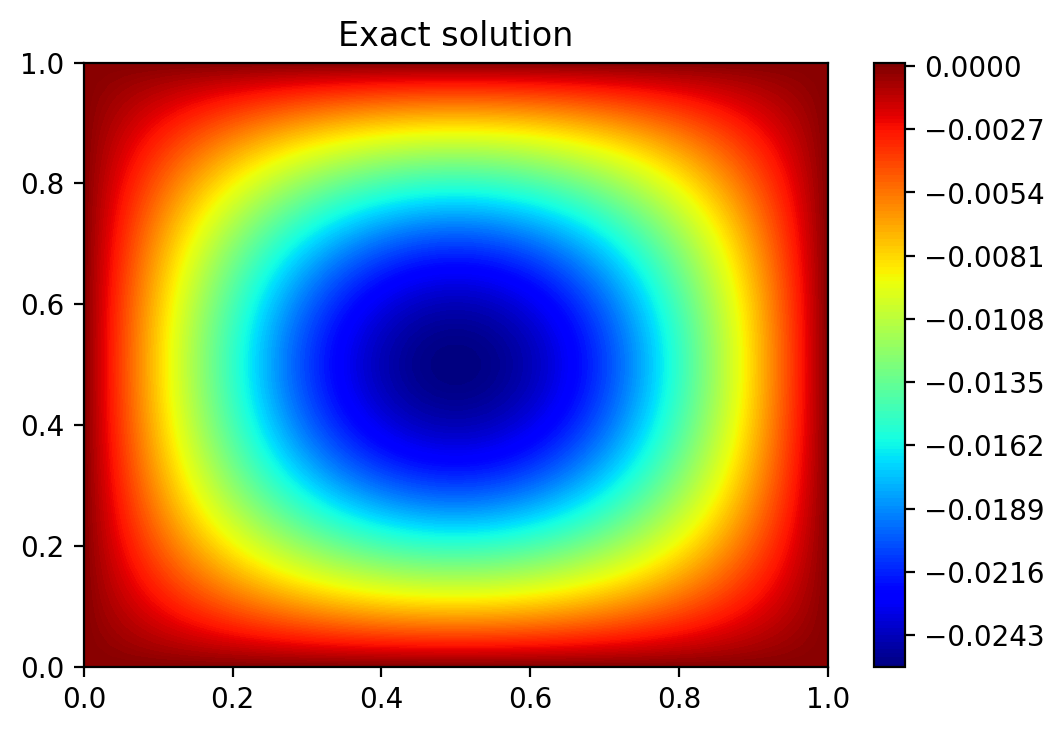

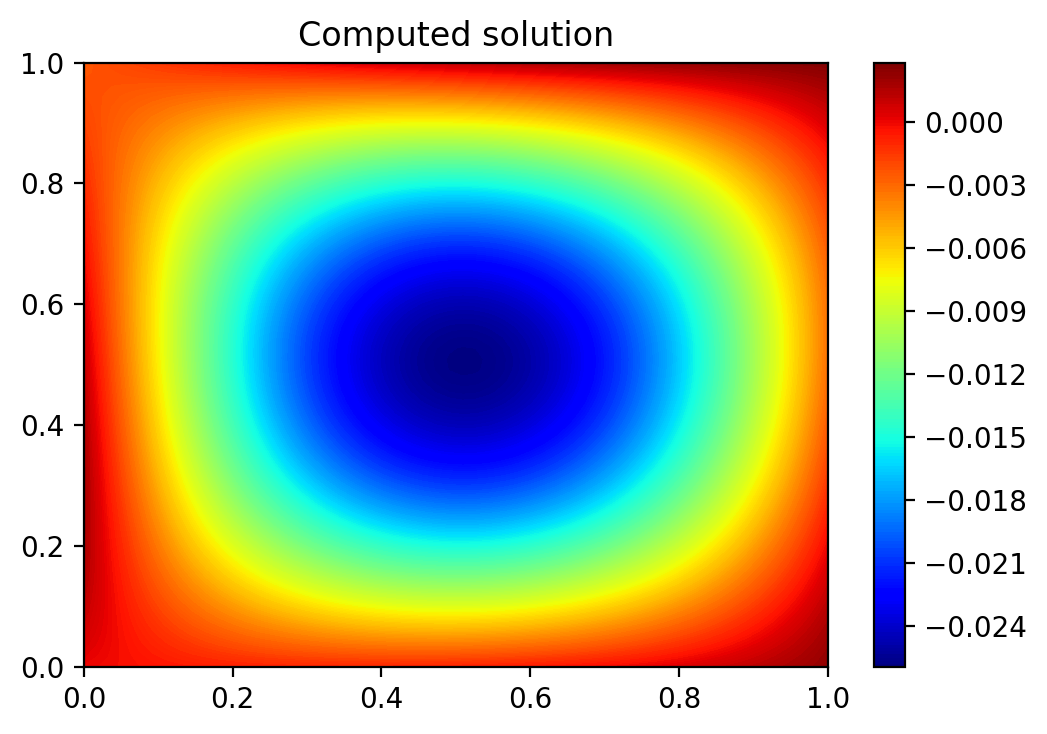

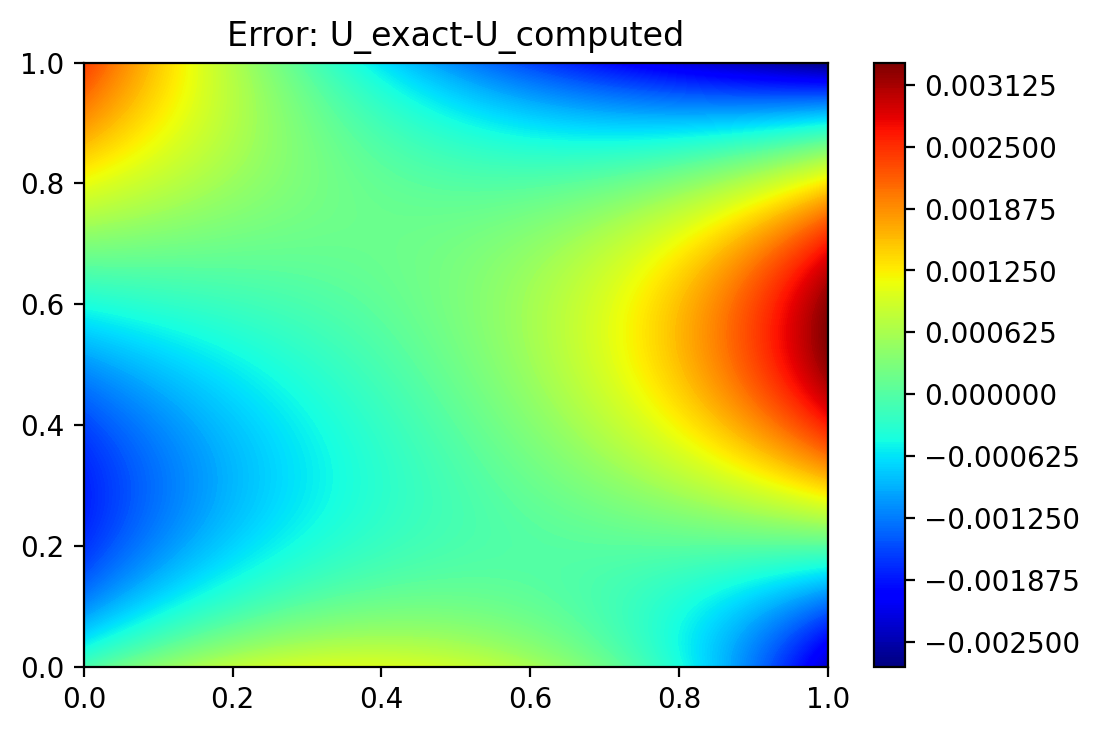

L2-error norm: 0.07518932968378067


In [10]:
    numPtsUTest = 2*numPtsU
    numPtsVTest = 2*numPtsV
    xPhysTest, yPhysTest = myQuad.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
    XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
    XTest_tf = tf.convert_to_tensor(XTest)
    YTest = pred_model(XTest_tf).numpy()    
    YExact = exact_sol(XTest[:,[0]], XTest[:,[1]])

    xPhysTest2D = np.resize(XTest[:,0], [numPtsUTest, numPtsVTest])
    yPhysTest2D = np.resize(XTest[:,1], [numPtsUTest, numPtsVTest])
    YExact2D = np.resize(YExact, [numPtsUTest, numPtsVTest])
    YTest2D = np.resize(YTest, [numPtsUTest, numPtsVTest])
    plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Exact solution")
    plt.savefig('PlateTfExact.pdf')
    plt.show()
    plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Computed solution")
    plt.savefig('PlateTfPredict.pdf')
    plt.show()
    plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D-YTest2D, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Error: U_exact-U_computed")
    plt.savefig('PlateTfError.pdf')
    plt.show()
    
    err = YExact - YTest
    print("L2-error norm: {}".format(np.linalg.norm(err)/np.linalg.norm(YTest)))